In [1]:
%matplotlib notebook
import math as m
import numpy as np
import scipy.constants as constants
import scipy.interpolate as inter
import matplotlib.pyplot as plt
from scipy import integrate
from jplephem.spk import SPK
from astropy.time import Time, TimeDelta
kernel = SPK.open('C:/Users/Nathan/Documents/Pyzo_Workspace/de430.bsp') # A adapter à son ordinateur

In [2]:
class Satellite:
    def __init__(self, epsilon, rayon, masse):
        self.epsilon = epsilon # Reflectivitée
        self.rayon = rayon
        self.masse = masse

# 1/ Définition des forces exercées
## a) Définition générique d'une force

In [3]:
class Force():
    def __init__(self):
        self.xpp = " A déterminer"
        self.ypp = " A déterminer"
        self.zpp = " A déterminer"
    
    def calculate(self, V, t):
        return("Error : définir calulate pour cette force")

## b) Définition précise des forces gravitationelles

Le modèle utilisé est celui de Newton $ \vec{F} = \frac{G M}{ r^{2}} \frac{\vec{r}}{r} $.

On regardera plus tard la différence avec la force dériveant du potentiel de Yukawa

In [4]:
class Gravitational_Force(Force):
    def __init__(self, n_body):
        self.Mu = [2.2032 * 10**(13), 3.24859 * 10**(14), 3.986004418 * 10**(14), 4.282837 * 10**(13), 1.26686534 * 10**(17), 3.7931187 * 10**(16), 5.793939 * 10**(15), 6.836529 * 10**(15), 8.71 * 10**(11), 1.32712440018 * 10**(20)] # m^3 / s^2
        self.n_body = n_body
        self.mu = self.Mu[n_body - 1]
        
    def calculate(self, V, t):
        t_day = t / 86400 # day
        x, y, z, xp, yp , zp = V
        position_attractor = kernel[0, self.n_body].compute(t_day)
        x_attractor, y_attractor, z_attractor = position_attractor * 1000 # m
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        
        self.xpp = - self.mu * (x - x_attractor) / d_attractor**3
        self.ypp = - self.mu * (y - y_attractor) / d_attractor**3
        self.zpp = - self.mu * (z - z_attractor) / d_attractor**3
        return(None)

## c) Définition précise de la pression de radiation solaire

Le modèle utilisée est celui de [2] (cannonball model) appliqué à une sphère $\vec{F} = \pi R^{2} (1 + \epsilon) \times \frac{L_{\odot}}{4 \pi r^{2}} \times \frac{1}{c} \times \frac{\vec{r}}{r}$ où $R$ est le rayon de la sphère et $\epsilon$ sa reflexivité.

In [5]:
class Force_Radiation(Force):

    def __init__ (self, satellite):
        self.L = 1367 * 4 * m.pi * constants.astronomical_unit**2 # W
        self.sat = satellite

    def calculate(self,V,t):
        t_day = t / 86400 # day
        
        x, y, z, xp, yp, zp = V
        
        position_sun = kernel[0, 9].compute(t_day)
        x_sun, y_sun, z_sun = position_sun * 1000 # m
        
        d_sun = m.sqrt((x - x_sun)**2 + (y - y_sun)**2 + (z - z_sun)**2)
        
        flux = self.L / (4 * m.pi * d_sun**2) # W.m^-2
        P = flux / constants.c
        F = m.pi * self.sat.rayon**2 * (1 + self.sat.epsilon) * P
        
        if (x - x_sun) > 0 :
            theta = m.atan((y - y_sun) / (x - x_sun))
        elif (x - x_sun) < 0 :
            theta = m.atan((y - y_sun) / (x - x_sun)) + m.pi
        elif (y - y_sun) >= 0 :
            theta = m.pi / 2
        else :
            theta = - m.pi /2
        phi = m.atan((z - z_sun)/(m.sqrt((x - x_sun)**2 + (y - y_sun)**2)))
        
        self.zpp = F * m.sin(phi) / self.sat.masse
        self.ypp = F * m.sin(theta) * m.cos(phi) / self.sat.masse
        self.xpp = F * m.cos(theta) * m.cos(phi) / self.sat.masse
        return (None)

## d) Définition précise de la force exercée par le vent solaire

Le modèle utilisé est analogue à celui de la pression de radiation, mais on se place dans un pire cas avec $\epsilon = 1$, et le flux est calculé à partir de l'énergie cinétique des protons émis par le soleil.
On a donc $\vec{F} = 2 \pi R^{2} \times \frac{n_{\odot}}{4 \pi r^{2}} \times  m_{p} \vec{v_{r}}$, où $\vec{v_{r}} = v_{ejection} \times \frac{\vec{r}}{r} - \vec{v_{satellite}}$ est la vitesse relative du vent par rapport au satellite.

La vitesse d'éjection $v_{ejection}$ des vents solaires par le soleil est comprise entre 300 et 800 $km / s$ d'après [3].

In [6]:
class Force_Vent(Force):

    def __init__(self, vitesse, satellite):
        self.n0 = 1.3 * 10**36   ## particules ejectees par seconde
        self.mp = 1.672 * 10**(-27)   ## masse du proton (ejection de plasma de H+)
        self.v = vitesse ## vitesse du plasma ejecte
        self.sat = satellite

    def calculate(self,V,t):
        t_day = t / 86400 # day
        
        x, y, z, xp, yp, zp = V
        
        position_sun = kernel[0, 9].compute(t_day)
        x_sun, y_sun, z_sun = position_sun * 1000 # m
        d_sun = m.sqrt((x - x_sun)**2 + (y - y_sun)**2 + (z - z_sun)**2)
        
        relative_velocity_x = self.v * (x - x_sun) / d_sun - xp
        relative_velocity_y = self.v * (y - y_sun) / d_sun - yp
        relative_velocity_z = self.v * (z - z_sun) / d_sun - zp
        relative_velocity = m.sqrt(relative_velocity_x**2 + relative_velocity_y**2 + relative_velocity_z**2)
        
        flux = self.mp * relative_velocity * self.n0 / (4 * m.pi * d_sun**2)
        F = 2 * m.pi * self.sat.rayon**2 * flux
        
        self.xpp = F * relative_velocity_x / (self.sat.masse * relative_velocity)
        self.ypp = F * relative_velocity_y / (self.sat.masse * relative_velocity)
        self.zpp = F * relative_velocity_z / (self.sat.masse * relative_velocity)
        return (None)

## e) Définition précise de la force dériveant du potentiel de Yukawa

Le modèle utilisé est celui de la force dériveant du potentiel de Yukawa $V(r) = - \frac{\mu}{r} [1 + \alpha e^{- r / \lambda}]$ [4]. 

Par $\vec{F} = - \vec{\nabla} V$  on obtient $\vec{F} = - \frac{\mu}{r^{2}} \times [1 + \alpha e^{- r / \lambda} (1 +  \frac{r}{\lambda})] \frac{\vec{r}}{r}$.

In [9]:
class Yukawa_Force(Force):
    
    def __init__(self, n_body):
        self.Mu = [2.2032 * 10**(13), 3.24859 * 10**(14), 3.986004418 * 10**(14), 4.282837 * 10**(13), 1.26686534 * 10**(17), 3.7931187 * 10**(16), 5.793939 * 10**(15), 6.836529 * 10**(15), 8.71 * 10**(11), 1.32712440018 * 10**(20)] # m^3 / s^2
        self.n_body = n_body
        self.mu = self.Mu[n_body - 1]
        
        self.alpha = 10**(-4) ## Entre 10-4 et 10-6  mais essayer avec un alpha de l'ordre de 1 pour etre sur que tout est bien 
        self.lambdaa = 10**12 ## doit etre de lordre de r
    
    def calculate(self, V, t):
        t_day = t / 86400 # day
        
        x, y, z, xp, yp , zp = V
        position_attractor = kernel[0, self.n_body].compute(t_day)
        x_attractor, y_attractor, z_attractor = position_attractor * 1000 # m
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        F = - self.mu * d_attractor**(-2) * (1 + self.alpha * m.exp(-d_attractor / self.lambdaa) * (1 + d_attractor / self.lambdaa))
        
        theta = m.atan2((y - y_attractor), (x - x-attractor))
        phi = m.atan((z - z_attractor) / (m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2)))
        
        self.xpp = F * m.cos(theta) * m.cos(phi)
        self.ypp = F * m.sin(theta) * m.cos(phi) 
        self.zpp = F * m.sin(phi)
        return(None)

# II/ Propagateur d'orbite

In [10]:
def propagateur(V, t, Forces, useless_arg):
    x, y, z, xp, yp, zp = V
    xpp = 0
    ypp = 0
    zpp = 0
    for f in Forces:
        f.calculate(V, t)
        xpp += f.xpp
        ypp += f.ypp
        zpp += f.zpp
    return [xp, yp, zp, xpp, ypp, zpp]

# III/ Tests

## a) Test de propagation keplerienne

<IPython.core.display.Javascript object>


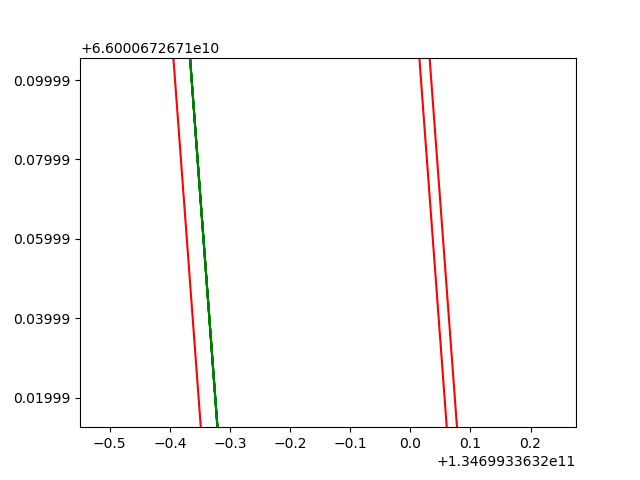

In [30]:
# paramètres de simulation
mu = 1.32712440018 * 10**(20)
a = 1.5 * 10**11
e = 0
p = a * (1 - e**2)
n = p / (1 + e)
b = a * m.sqrt(1 - e**2)
duration = 3 * m.sqrt((2 * m.pi)**2 * a**3 / mu)
k = 6 # ordre de précision

# définition des forces
'''on redéfinit localement une classe de force gravitationelle avec un attracteur fixe''' 
class Gravitational_Force_Test_1(Force):
    def __init__(self):
        self.mu = mu
        return
        
    def calculate(self, V, t):
        t_day = t / 86400 # day
        x, y, z, xp, yp , zp = V
        position_attractor = (0, 0, 0)
        x_attractor, y_attractor, z_attractor = position_attractor
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        
        self.xpp = - self.mu * (x - x_attractor) / d_attractor**3
        self.ypp = - self.mu * (y - y_attractor) / d_attractor**3
        self.zpp = - self.mu * (z - z_attractor) / d_attractor**3
        return(None)
force = Gravitational_Force_Test_1()
Forces = [force]

# conditions initiales
x0, y0, z0, xp0, yp0, zp0 = n, 0, 0, 0, m.sqrt(mu / p) * (1 + e), 0
V0 = [x0, y0, z0, xp0, yp0, zp0]

# propagation d'orbite
t = np.linspace(0, duration, num = 10**k)
solution = integrate.odeint(propagateur, V0, t, args = (Forces, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X, Y, Z = solution[:, 0], solution[:, 1], solution[:, 2]

# calcul de nu(t)
T = []
Nu = np.linspace(0, 2 * m.pi, 10**k)
for nu in Nu:
    E = 2 * m.atan(m.sqrt(1 - e) * m.tan(nu / 2) / m.sqrt(1 + e))
    M = E - e * m.sin(E)
    if M < 0:
        M += 2 * m.pi
    T.append(M * m.sqrt(a**3 / mu))
nu_de_t = inter.interp1d(T, Nu, bounds_error = False, fill_value = 'extrapolate')

# calcul de l'orbite théorique
X_theorique = []
Y_theorique = []
for i in range(len(t)):
    time = t[i]
    nu = nu_de_t(time)
    r = a * (1 - e**2) / (1 + e * m.cos(nu))
    X_theorique.append(r * m.cos(nu))
    Y_theorique.append(r * m.sin(nu))

# dessin
plt.figure(1)
plt.plot(X, Y, 'r')
plt.plot(X_theorique, Y_theorique, 'g')
plt.show()

$Conclusion :$ On observe après 3 ans d'évolution une différence de $72m$ entre la courbe théorique et la courbe numérique. On peut augmenter cette précision en échange d'un temps de calcul augmenté.

$Remarque :$ Il faut un pas de temps maximum de 31.5s pour avoir un résultat acceptable.

## b) Test de propagation par pression de radiation

c:\users\nathan\appdata\local\programs\python\python37-32\lib\site-packages\scipy\integrate\odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


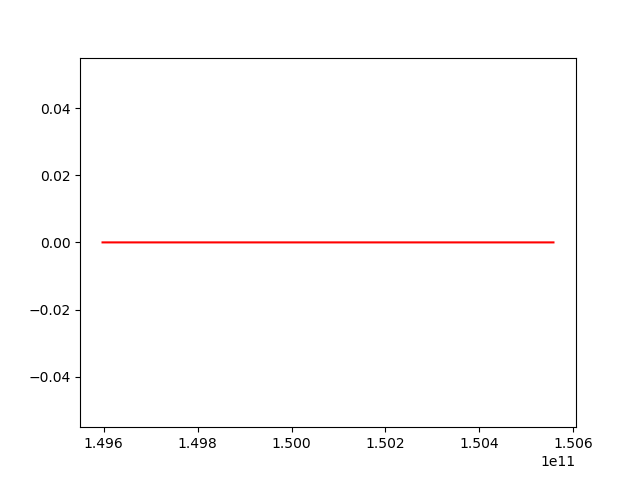

In [10]:
# Conditions initiales
x0, y0, z0, xp0, yp0, zp0 = constants.astronomical_unit, 0, 0, 0, 0, 0
V0 = [x0, y0, z0, xp0, yp0, zp0]
duration = 3 * 86400 * 365
k = 6 # ordre de précision

# Définition des forces
'''on redéfinit localement une classe de force de pression radiative avec une source unique fixe'''
class Force_Radiation_Test(Force):

    def __init__ (self, satellite):
        self.L = 1367 * 4 * m.pi * constants.astronomical_unit**2 # W
        self.sat = satellite

    def calculate(self,V,t):
        x, y, z, xp, yp, zp = V
        r = m.sqrt(x**2 + y**2 + z**2)
        
        flux = self.L / (4 * m.pi * r**2) # W.m^-2
        P = flux / constants.c
        F = m.pi * self.sat.rayon**2 * (1 + self.sat.epsilon) * P
        
        if x > 0 :
            theta = m.atan(y / x)
        elif x < 0 :
            theta = m.atan(y / x) + m.pi
        elif y >= 0 :
            theta = m.pi / 2
        else :
            theta = - m.pi /2
        phi = m.atan(z/(m.sqrt(x**2 + y**2)))
        
        self.zpp = F * m.sin(phi) / self.sat.masse
        self.ypp = F * m.sin(theta) * m.cos(phi) / self.sat.masse
        self.xpp = F * m.cos(theta) * m.cos(phi) / self.sat.masse
        return (None)
satellite = Satellite(0.5, 1, 100)
Forces = [Force_Radiation_Test(satellite)]

# Propagation d'orbite
t = np.linspace(0, duration, num = 10**k)
solution = integrate.odeint(propagateur, V0, t, args = (Forces, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X, Y, Z = solution[:, 0], solution[:, 1], solution[:, 2]

# Dessin
plt.figure(2)
plt.plot(X, Y, 'r')
plt.show()

$Conclusion :$ On obtient un déplacement purement selon x, ce qui est qualitativement attendu. On a eu un déplacement de $9.59593870 ~ 10^{8} m$. C'est l'ordre de grandeur attendu par la formule.

## c) Test de propagation par vent solaire

!!! TO BE DONE !!!

<IPython.core.display.Javascript object>


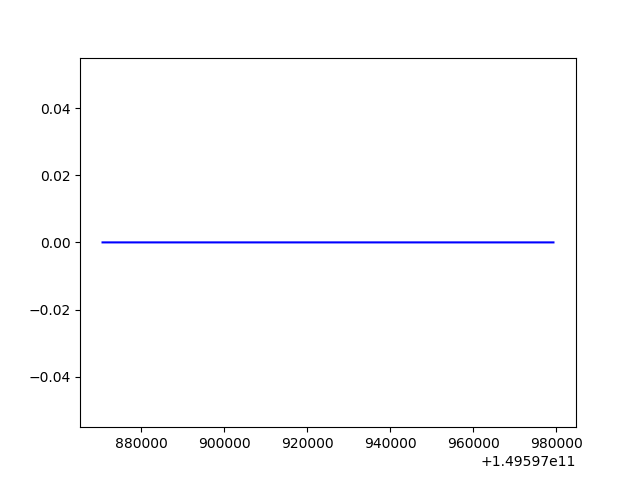

In [21]:
# Conditions initiales
x0, y0, z0, xp0, yp0, zp0 = constants.astronomical_unit, 0, 0, 0, 0, 0
V0 = [x0, y0, z0, xp0, yp0, zp0]
duration = 365 * 86400
k = 6 # ordre de précision

# Définition des forces
'''on redéfinit localement une classe de force du vent solaire avec une source unique fixe'''
class Force_Vent_Test(Force):

    def __init__(self, vitesse, satellite):
        self.n0 = 1.3 * 10**36   ## particules ejectees par seconde
        self.mp = 1.672 * 10**(-27)   ## masse du proton (ejection de plasma de H+)
        self.v = vitesse ## vitesse du plasma ejecte
        self.sat = satellite

    def calculate(self,V,t):
        x, y, z, xp, yp, zp = V
        r = m.sqrt(x**2 + y**2 + z**2)
        flux = self.mp * self.v * self.n0 / (4 * m.pi * r**2)
        F = 2 * m.pi * self.sat.rayon**2 * flux
        
        if x > 0 :
            theta = m.atan(y/x)
        elif x < 0 :
            theta = m.atan(y / x) + m.pi
        elif y >= 0 :
            theta = m.pi / 2
        else :
            theta = - m.pi /2
        phi = m.atan(z/(m.sqrt(x**2 + y**2)))
        
        self.zpp = F * m.sin(phi) / self.sat.masse
        self.ypp = F * m.sin(theta) * m.cos(phi) / self.sat.masse
        self.xpp = F * m.cos(theta) * m.cos(phi) / self.sat.masse
        return (None)
satellite = Satellite(0.5, 1, 100)
vitesse = 450000
Forces = [Force_Vent_Test(vitesse, satellite)]

# Propagation d'orbite
t = np.linspace(0, duration, num = 10**k)
solution = integrate.odeint(propagateur, V0, t, args = (Forces, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X, Y, Z = solution[:, 0], solution[:, 1], solution[:, 2]

# Dessin
plt.figure(3)
plt.plot(X, Y, 'b')
plt.show()

$Conclusion :$ On obtient un déplacement purement selon x, ce qui était qualitativement attendu. On a un déplacement de $1.08666 ~ 10^{5} m$. C'est l'ordre de grandeur attendu par le formule.

## d) Test de propagation sous le potentiel de Yukawa

In [12]:
# paramètres de simulation
mu = 1.32712440018 * 10**(20)
a = 1.5 * 10**11
e = 0
p = a * (1 - e**2)
n = p / (1 + e)
b = a * m.sqrt(1 - e**2)
duration = 3 * m.sqrt((2 * m.pi)**2 * a**3 / mu)
k = 6 # ordre de précision

# définition des forces
'''on redéfinit localement une classe de force gravitationelle avec un attracteur fixe''' 
class Gravitational_Force_Test_1(Force):
    def __init__(self):
        self.mu = mu
        return
        
    def calculate(self, V, t):
        t_day = t / 86400 # day
        x, y, z, xp, yp , zp = V
        position_attractor = (0, 0, 0)
        x_attractor, y_attractor, z_attractor = position_attractor
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        
        self.xpp = - self.mu * (x - x_attractor) / d_attractor**3
        self.ypp = - self.mu * (y - y_attractor) / d_attractor**3
        self.zpp = - self.mu * (z - z_attractor) / d_attractor**3
        return(None)

c:\users\nathan\appdata\local\programs\python\python37-32\lib\site-packages\scipy\integrate\odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


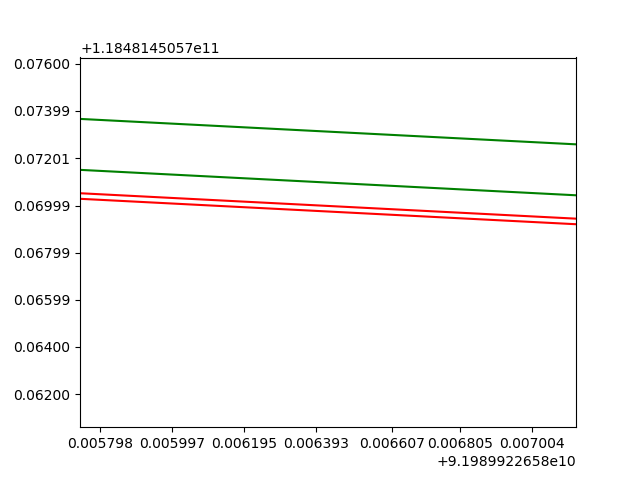

In [13]:
# paramètres de simulation
mu = 1.32712440018 * 10**(20)
a = 1.5 * 10**11
e = 0
p = a * (1 - e**2)
n = p / (1 + e)
b = a * m.sqrt(1 - e**2)
duration = 3 * m.sqrt((2 * m.pi)**2 * a**3 / mu)
k = 6 # ordre de précision

# Définition des forces
'''on redéfinit localement une classe de force gravitationelle de Yukawa, avec un attracteur fixe'''
class Yukawa_Force_Test(Force):
    
    def __init__(self):
        self.mu = mu
        self.alpha = 1
        self.lambdaa = 10000000 * a
    
    def calculate(self, V, t):
        x, y, z, xp, yp , zp = V
        position_attractor = (0, 0, 0)
        x_attractor, y_attractor, z_attractor = position_attractor # m
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        F = - self.mu * d_attractor**(-2) * (self.alpha * m.exp(-d_attractor / self.lambdaa) * (1 + d_attractor / self.lambdaa))
        
        theta = m.atan2(y - y_attractor, x - x_attractor)
        phi = m.atan((z - z_attractor) / (m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2)))
        
        self.xpp = F * m.cos(theta) * m.cos(phi)
        self.ypp = F * m.sin(theta) * m.cos(phi) 
        self.zpp = F * m.sin(phi)
        return(None)
force_1 = Yukawa_Force_Test()
force_2 = Gravitational_Force_Test_1()
Forces_1 = [force_1]
Forces_2 = [force_2]

# conditions initiales
x1, y1, z1, xp1, yp1, zp1 = n, 0, 0, 0, m.sqrt(mu / p) * (1 + e), 0
x2, y2, z2, xp2, yp2, zp2 = n, 0, 0, 0, m.sqrt(mu / p) * (1 + e), 0
V1 = [x1, y1, z1, xp1, yp1, zp1]
V2 = [x2, y2, z2, xp2, yp2, zp2]

# propagation d'orbite
t = np.linspace(0, duration, num = 10**k)
solution_1 = integrate.odeint(propagateur, V1, t, args = (Forces_1, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_1, Y_1, Z_1 = solution_1[:, 0], solution_1[:, 1], solution_1[:, 2]
solution_2 = integrate.odeint(propagateur, V2, t, args = (Forces_2, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_2, Y_2, Z_2 = solution_2[:, 0], solution_2[:, 1], solution_2[:, 2]

# dessin
plt.figure(9)
plt.plot(X_1, Y_1, 'r')
plt.plot(X_2, Y_2, 'g')
plt.show()

In [14]:
print(m.sqrt((X_2[-1] - X_1[-1])**2 + (Y_2[-1] - Y_1[-1])**2))

0.027074873442099218


27 mm d'écart après 3 ans : l'implémentation est validée

## e) Test des niveaux de forces

<IPython.core.display.Javascript object>


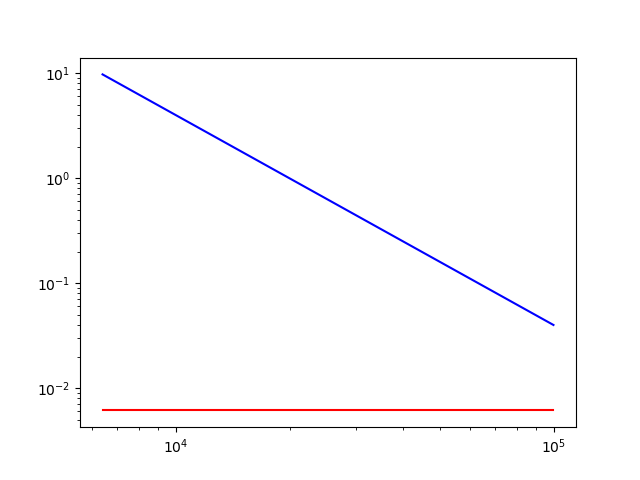

In [14]:
# Définition des forces
'''on redéfinit localement une classe de force gravitationelle avec un attracteur au niveau de la Terre''' 
class Gravitational_Force_Test_2(Force):
    def __init__(self, n_body):
        self.mu = [2.2032 * 10**(13), 3.24859 * 10**(14), 3.986004418 * 10**(14), 4.282837 * 10**(13), 1.26686534 * 10**(17), 3.7931187 * 10**(16), 5.793939 * 10**(15), 6.836529 * 10**(15), 8.71 * 10**(11), 1.32712440018 * 10**(20)] # m^3 / s^2
        self.n_body = n_body
        
    def calculate(self, V, t):
        t_day = t / 86400 # day
        x, y, z, xp, yp , zp = V
        position_attractor = kernel[0, self.n_body].compute(t_day)
        position_attractor -= kernel[0, 3].compute(t_day)
        #position_attractor -= kernel[3, 399].compute(t_day)
        x_attractor, y_attractor, z_attractor = position_attractor * 1000 # m
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        
        self.xpp = - self.mu[self.n_body - 1] * (x - x_attractor) / d_attractor**3
        self.ypp = - self.mu[self.n_body - 1] * (y - y_attractor) / d_attractor**3
        self.zpp = - self.mu[self.n_body - 1] * (z - z_attractor) / d_attractor**3
        return(None)
force_earth = Gravitational_Force_Test_2(3)
force_sun = Gravitational_Force_Test_2(10)
Forces = [force_earth, force_sun]

# Définition des temps
time_isot = "2050-01-01T00:00:00"
Times_isot = [time_isot]
T = Time(Times_isot, format = 'isot', scale = 'utc')
Times_jd = T.jd
t = Times_jd[0] * 86400

# Position de référence dans le référentiel de la Terre (399)
x0, y0, z0, xp0, yp0, zp0 = 0, 0, 0, 0, 0, 0
V0 = [x0, y0, z0, xp0, yp0, zp0]

# Calcul des forces
H = []
Earth = []
Sun = []
for h in range(6400, 100000, 100):
    x, y, z, vx, vy, vz = V0
    x = 1000 * h
    V = [x, y, z, vx, vy, vz]
    
    Forces[0].calculate(V, t)
    xpp, ypp, zpp = Forces[0].xpp, Forces[0].ypp, Forces[0].zpp 
    a_earth = m.sqrt(xpp**2 + ypp**2 + zpp**2)
    Forces[1].calculate(V, t)
    xpp, ypp, zpp = Forces[1].xpp, Forces[1].ypp, Forces[1].zpp
    a_sun = m.sqrt(xpp**2 + ypp**2 + zpp**2)
    
    H.append(h)
    Earth.append(a_earth)
    Sun.append(a_sun)

# Dessin
plt.figure(4)
plt.xscale("log")
plt.yscale("log")
plt.plot(H, Earth, 'b')
plt.plot(H, Sun, 'r')
plt.show()

Il faut prendre en compte une force d'inertie pour le terme solaire, car on est dans le referentiel terrestre.

# IV/ Calculs

## a) Influence de Jupiter

In [ ]:
# définition des temps
time_isot_start = "2050-01-01T00:00:00"
time_isot_end = "2050-02-01T00:00:00"
Times_isot = [time_isot_start, time_isot_end]
T = Time(Times_isot, format = 'isot', scale = 'utc')
Times_jd = T.jd
time_jd_start, time_jd_end = Times_jd
time_jd_start *= 86400
time_jd_end *= 86400
n_points = 10**6

# conditions initiales
position0, velocity0 = kernel[0, 9].compute_and_differentiate(time_jd_start / 86400)
x0, y0, z0 = position0 * 1000 # m
x0 += 10**(11) # on s'éloigne de Pluton d'une unité astronomique
xp0, yp0, zp0 = velocity0
wrong_celerity = m.sqrt(xp0**2 + yp0**2 + zp0**2)
right_celerity = constants.c * 0.0005
xp0 = xp0 * right_celerity / wrong_celerity # m /s
yp0 = yp0 * right_celerity / wrong_celerity # m /s
zp0 = zp0 * right_celerity / wrong_celerity # m /s
V0 = [x0, y0, z0, xp0, yp0, zp0]

# définition des forces avec tous les corps
Forces_sun_and_jupyter = []
for n_body in range(1,11):
    if ((n_body == 10) or (n_body == 5)):
        force = Gravitational_Force(n_body)
        Forces_sun_and_jupyter.append(force)
# définition des forces avec juste le soleil
Forces_sun = []
for n_body in range(1,11):
    if (n_body == 10):
        force = Gravitational_Force(n_body)
        Forces_sun.append(force)

# propagation d'orbite
t = np.linspace(time_jd_start, time_jd_end, n_points)

V01 = V0[:]
solution = integrate.odeint(propagateur, V01, t, args = (Forces_sun_and_jupyter, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_sun_and_jupyter, Y_sun_and_jupyter, Z_sun_and_jupyter = solution[:, 0], solution[:, 1], solution[:, 2]

V02 = V0[:]
solution_2 = integrate.odeint(propagateur, V02, t, args = (Forces_sun, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_sun, Y_sun, Z_sun = solution_2[:, 0], solution_2[:, 1], solution_2[:, 2]

# sauvegarde
X_sun, Y_sun, Z_sun = np.asarray(X_sun), np.asarray(Y_sun), np.asarray(Z_sun)
np.savetxt("Tests_algorithme\\X_sun_1_month", X_sun)
np.savetxt("Tests_algorithme\\Y_sun_1_month", Y_sun)
np.savetxt("Tests_algorithme\\Z_sun_1_month", Z_sun)

X_sun_and_jupyter, Y_sun_and_jupyter, Z_sun_and_jupyter = np.asarray(X_sun_and_jupyter), np.asarray(Y_sun_and_jupyter), np.asarray(Z_sun_and_jupyter)
np.savetxt("Tests_algorithme\\X_sun_and_jupyter_1_month", X_sun_and_jupyter)
np.savetxt("Tests_algorithme\\Y_sun_and_jupyter_1_month", Y_sun_and_jupyter)
np.savetxt("Tests_algorithme\\Z_sun_and_jupyter_1_month", Z_sun_and_jupyter)

<IPython.core.display.Javascript object>


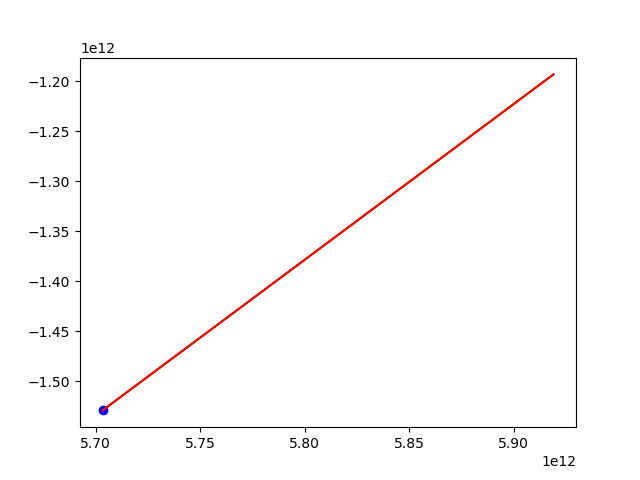

9492.191397177065


In [38]:
# récupération des données
t = np.linspace(time_jd_start, time_jd_end, n_points)
X_sun = np.loadtxt("Tests_algorithme\\X_sun_1_month")
Y_sun = np.loadtxt("Tests_algorithme\\Y_sun_1_month")
Z_sun = np.loadtxt("Tests_algorithme\\Z_sun_1_month")

X_sun_and_jupyter = np.loadtxt("Tests_algorithme\\X_sun_and_jupyter_1_month")
Y_sun_and_jupyter = np.loadtxt("Tests_algorithme\\Y_sun_and_jupyter_1_month")
Z_sun_and_jupyter = np.loadtxt("Tests_algorithme\\Z_sun_and_jupyter_1_month")

# dessin
plt.figure(5)
plt.scatter(X_sun[0], Y_sun[0], c = "b")
plt.plot(X_sun_and_jupyter, Y_sun_and_jupyter, 'g')
plt.plot(X_sun, Y_sun, 'r')
plt.show()
print(m.sqrt((X_sun_and_jupyter[-1] - X_sun[-1])**2 + (Y_sun_and_jupyter[-1] - Y_sun[-1])**2 + (Z_sun_and_jupyter[-1] - Z_sun[-1])**2))

$Conclusion :$ On aboutit à une différence de $9492 \pm 3$ m après 1 mois d'évolution. La vitesse initiale est très importante donc la trajectoire est quasi rectiligne.

 ## b) Influence des autres planètes

In [ ]:
# définition des temps
time_isot_start = "2050-01-01T00:00:00"
time_isot_end = "2050-02-01T00:00:00"
Times_isot = [time_isot_start, time_isot_end]
T = Time(Times_isot, format = 'isot', scale = 'utc')
Times_jd = T.jd
time_jd_start, time_jd_end = Times_jd
time_jd_start *= 86400
time_jd_end *= 86400
n_points = 10**6

# conditions initiales
position0, velocity0 = kernel[0, 9].compute_and_differentiate(time_jd_start / 86400)
x0, y0, z0 = position0 * 1000 # m
x0 += 10**(11) # on s'éloigne de Pluton d'une unité astronomique
xp0, yp0, zp0 = velocity0
wrong_celerity = m.sqrt(xp0**2 + yp0**2 + zp0**2)
right_celerity = constants.c * 0.0005
xp0 = xp0 * right_celerity / wrong_celerity # m /s
yp0 = yp0 * right_celerity / wrong_celerity # m /s
zp0 = zp0 * right_celerity / wrong_celerity # m /s
V0 = [x0, y0, z0, xp0, yp0, zp0]

# définition des forces avec toutes les planètes
Forces_all_planets = []
for n_body in range(1,11):
    if (n_body != 3):
        force = Gravitational_Force(n_body)
        Forces_all_planets.append(force)

# propagation d'orbite
t = np.linspace(time_jd_start, time_jd_end, n_points)

V03 = V0[:]
solution = integrate.odeint(propagateur, V03, t, args = (Forces_all_planets, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_all_planets, Y_all_planets, Z_all_planets = solution[:, 0], solution[:, 1], solution[:, 2]

# sauvegarde
X_all_planets, Y_all_planets, Z_all_planets = np.asarray(X_all_planets), np.asarray(Y_all_planets), np.asarray(Z_all_planets)
np.savetxt("Tests_algorithme\\X_all_planets_1_month", X_all_planets)
np.savetxt("Tests_algorithme\\Y_all_planets_1_month", Y_all_planets)
np.savetxt("Tests_algorithme\\Z_all_planets_1_month", Z_all_planets)

<IPython.core.display.Javascript object>


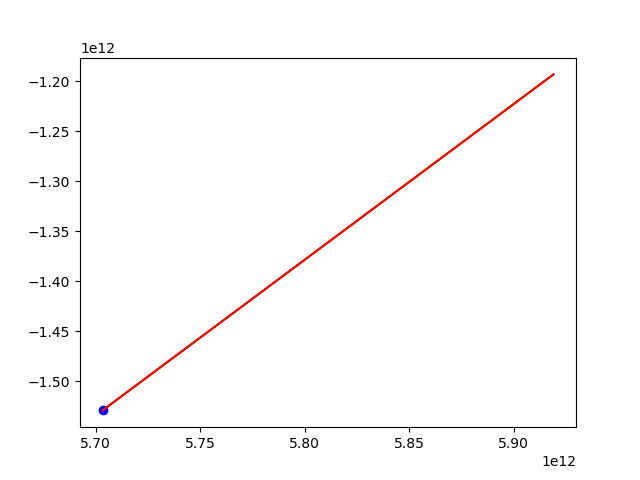

5562.927410921063


In [39]:
Tests_algorithme\\# récupération des données
t = np.linspace(time_jd_start, time_jd_end, n_points)
X_all_planets = np.loadtxt("Tests_algorithme\\X_all_planets_1_month")
Y_all_planets = np.loadtxt("Tests_algorithme\\Y_all_planets_1_month")
Z_all_planets = np.loadtxt("Tests_algorithme\\Z_all_planets_1_month")

X_sun_and_jupyter = np.loadtxt("Tests_algorithme\\X_sun_and_jupyter_1_month")
Y_sun_and_jupyter = np.loadtxt("Tests_algorithme\\Y_sun_and_jupyter_1_month")
Z_sun_and_jupyter = np.loadtxt("Tests_algorithme\\Z_sun_and_jupyter_1_month")

# dessin
plt.figure(6)
plt.scatter(X_sun[0], Y_sun[0], c = "b")
plt.plot(X_all_planets, Y_all_planets, 'g')
plt.plot(X_sun_and_jupyter, Y_sun_and_jupyter, 'r')
plt.show()
print(m.sqrt((X_all_planets[-1] - X_sun_and_jupyter[-1])**2 + (Y_all_planets[-1] - Y_sun_and_jupyter[-1])**2 + (Z_all_planets[-1] - Z_sun_and_jupyter[-1])**2))

$Conclusion :$ On aboutit à une différence de $5563 \pm 3$ m après 1 mois d'évolution. La vitesse initiale est très importante donc la trajectoire est quasi rectiligne.

## c) Influence des autres forces

In [ ]:
# définition des temps
time_isot_start = "2050-01-01T00:00:00"
time_isot_end = "2050-02-01T00:00:00"
Times_isot = [time_isot_start, time_isot_end]
T = Time(Times_isot, format = 'isot', scale = 'utc')
Times_jd = T.jd
time_jd_start, time_jd_end = Times_jd
time_jd_start *= 86400
time_jd_end *= 86400
n_points = 10**6

# définition du satellite
satellite = Satellite(0.5, 0.63, 1000)

# conditions initiales
position0, velocity0 = kernel[0, 9].compute_and_differentiate(time_jd_start / 86400)
x0, y0, z0 = position0 * 1000 # m
x0 += 10**(11) # on s'éloigne de Pluton d'une unité astronomique
xp0, yp0, zp0 = velocity0
wrong_celerity = m.sqrt(xp0**2 + yp0**2 + zp0**2)
right_celerity = constants.c * 0.0005
xp0 = xp0 * right_celerity / wrong_celerity # m /s
yp0 = yp0 * right_celerity / wrong_celerity # m /s
zp0 = zp0 * right_celerity / wrong_celerity # m /s
V0 = [x0, y0, z0, xp0, yp0, zp0]

# définition des forces
Forces_all_forces = []
for n_body in range(1,11):
    if (n_body != 3):
        force = Gravitational_Force(n_body)
        Forces_all_forces.append(force)
force = Force_Radiation(satellite)
Forces_all_forces.append(force)
force = Force_Vent(450000, satellite)
Forces_all_forces.append(force)

# propagation d'orbite
t = np.linspace(time_jd_start, time_jd_end, n_points)

V04 = V0[:]
solution = integrate.odeint(propagateur, V03, t, args = (Forces_all_forces, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_all_forces, Y_all_forces, Z_all_forces = solution[:, 0], solution[:, 1], solution[:, 2]

# sauvegarde
X_all_forces, Y_all_forces, Z_all_forces = np.asarray(X_all_forces), np.asarray(Y_all_forces), np.asarray(Z_all_forces)
np.savetxt("Tests_algorithme\\X_all_forces_1_month", X_all_forces)
np.savetxt("Tests_algorithme\\Y_all_forces_1_month", Y_all_forces)
np.savetxt("Tests_algorithme\\Z_all_forces_1_month", Z_all_forces)

<IPython.core.display.Javascript object>


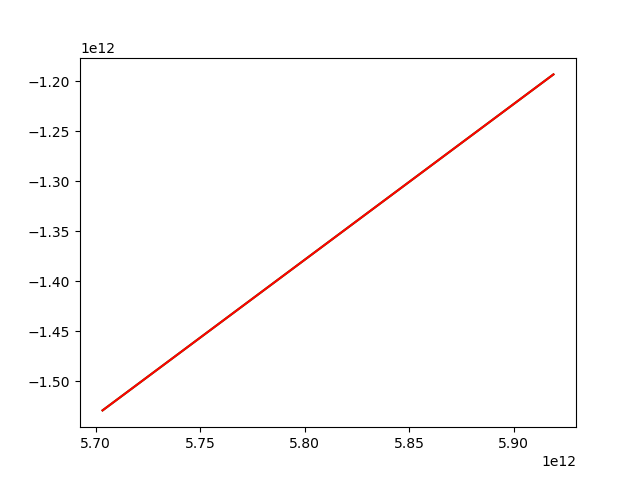

24548.617791765722


In [40]:
# récupération des données
t = np.linspace(time_jd_start, time_jd_end, n_points)
X_all_forces = np.loadtxt("Tests_algorithme\\X_all_forces_1_month")
Y_all_forces = np.loadtxt("Tests_algorithme\\Y_all_forces_1_month")
Z_all_forces = np.loadtxt("Tests_algorithme\\Z_all_forces_1_month")

X_all_planets = np.loadtxt("Tests_algorithme\\X_all_planets_1_month")
Y_all_planets = np.loadtxt("Tests_algorithme\\Y_all_planets_1_month")
Z_all_planets = np.loadtxt("Tests_algorithme\\Z_all_planets_1_month")

# dessin
plt.figure(7)
plt.plot(X_all_forces, Y_all_forces, 'g')
plt.plot(X_all_planets, Y_all_planets, 'r')
plt.show()
print(m.sqrt((X_all_forces[-1] - X_all_planets[-1])**2 + (Y_all_forces[-1] - Y_all_planets[-1])**2 + (Z_all_forces[-1] - Z_all_planets[-1])**2))

$Conclusion :$ On aboutit à une différence de $24549 \pm ?$ m après 1 mois d'évolution. La vitesse initiale est très importante donc la trajectoire est quasi rectiligne.

## d) Différence entre le protentiel de Newton et le potentiel de Yukawa

In [ ]:
# définition des temps
time_isot_start = "2050-01-01T00:00:00"
time_isot_end = "2050-02-01T00:00:00"
Times_isot = [time_isot_start, time_isot_end]
T = Time(Times_isot, format = 'isot', scale = 'utc')
Times_jd = T.jd
time_jd_start, time_jd_end = Times_jd
time_jd_start *= 86400
time_jd_end *= 86400
n_points = 10**6

# définition du satellite
satellite = Satellite(0.5, 0.63, 1000)

# conditions initiales
position0, velocity0 = kernel[0, 9].compute_and_differentiate(time_jd_start / 86400)
x0, y0, z0 = position0 * 1000 # m
x0 += 10**(11) # on s'éloigne de Pluton d'une unité astronomique
xp0, yp0, zp0 = velocity0
wrong_celerity = m.sqrt(xp0**2 + yp0**2 + zp0**2)
right_celerity = constants.c * 0.0005
xp0 = xp0 * right_celerity / wrong_celerity # m /s
yp0 = yp0 * right_celerity / wrong_celerity # m /s
zp0 = zp0 * right_celerity / wrong_celerity # m /s
V0 = [x0, y0, z0, xp0, yp0, zp0]

# définition des forces
Forces_Yukawa = []
for n_body in range(1,11):
    if (n_body != 3):
        force = Yukawa_Force(n_body)
        Forces_Yukawa.append(force)
force = Force_Radiation(satellite)
Forces_Yukawa.append(force)
force = Force_Vent(450000, satellite)
Forces_Yukawa.append(force)

# propagation d'orbite
t = np.linspace(time_jd_start, time_jd_end, n_points)

V04 = V0[:]
solution = integrate.odeint(propagateur, V04, t, args = (Forces_Yukawa, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_Yukawa, Y_Yukawa, Z_Yukawa = solution[:, 0], solution[:, 1], solution[:, 2]

# sauvegarde
X_Yukawa, Y_Yukawa, Z_Yukawa = np.asarray(X_Yukawa), np.asarray(Y_Yukawa), np.asarray(Z_Yukawa)
np.savetxt("Tests_algorithme\\X_Yukawa_1_month", X_Yukawa)
np.savetxt("Tests_algorithme\\Y_Yukawa_1_month", Y_Yukawa)
np.savetxt("Tests_algorithme\\Z_Yukawa_1_month", Z_Yukawa)

<IPython.core.display.Javascript object>


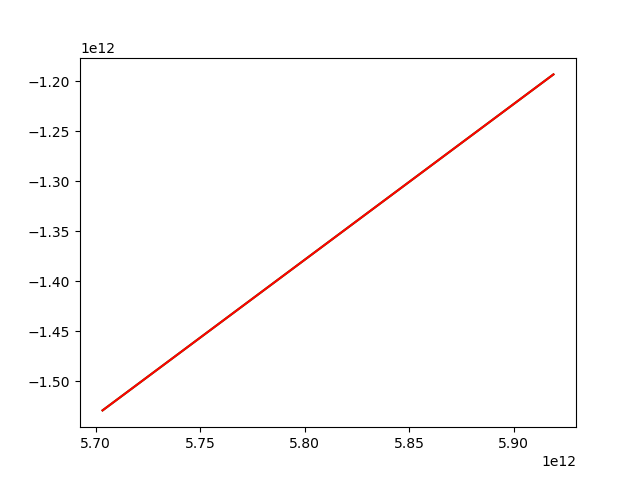

15.434347923580995


In [2]:
# récupération des données
t = np.linspace(time_jd_start, time_jd_end, n_points)
X_Yukawa = np.loadtxt("Tests_algorithme\\X_Yukawa_1_month")
Y_Yukawa = np.loadtxt("Tests_algorithme\\Y_Yukawa_1_month")
Z_Yukawa = np.loadtxt("Tests_algorithme\\Z_Yukawa_1_month")

X_all_forces = np.loadtxt("Tests_algorithme\\X_all_forces_1_month")
Y_all_forces = np.loadtxt("Tests_algorithme\\Y_all_forces_1_month")
Z_all_forces = np.loadtxt("Tests_algorithme\\Z_all_forces_1_month")

# dessin
plt.figure(7)
plt.plot(X_Yukawa, Y_Yukawa, 'g')
plt.plot(X_all_forces, Y_all_forces, 'r')
plt.show()
print(m.sqrt((X_Yukawa[-1] - X_all_forces[-1])**2 + (Y_Yukawa[-1] - Y_all_forces[-1])**2 + (Z_Yukawa[-1] - Z_all_forces[-1])**2))

$Conclusion :$ On aboutit à une différence de $15 \pm ?$ m après 1 mois d'évolution.

In [ ]:
# Charger toutes les données
X_sun = np.loadtxt("Tests_algorithme\\X_sun_1_month")
Y_sun = np.loadtxt("Tests_algorithme\\Y_sun_1_month")
Z_sun = np.loadtxt("Tests_algorithme\\Z_sun_1_month")

X_sun_and_jupyter = np.loadtxt("Tests_algorithme\\X_sun_and_jupyter_1_month")
Y_sun_and_jupyter = np.loadtxt("Tests_algorithme\\Y_sun_and_jupyter_1_month")
Z_sun_and_jupyter = np.loadtxt("Tests_algorithme\\Z_sun_and_jupyter_1_month")

X_all_planets = np.loadtxt("Tests_algorithme\\X_all_planets_1_month")
Y_all_planets = np.loadtxt("Tests_algorithme\\Y_all_planets_1_month")
Z_all_planets = np.loadtxt("Tests_algorithme\\Z_all_planets_1_month")

X_all_forces = np.loadtxt("Tests_algorithme\\X_all_forces_1_month")
Y_all_forces = np.loadtxt("Tests_algorithme\\Y_all_forces_1_month")
Z_all_forces = np.loadtxt("Tests_algorithme\\Z_all_forces_1_month")

X_Yukawa = np.loadtxt("Tests_algorithme\\X_Yukawa_1_month")
Y_Yukawa = np.loadtxt("Tests_algorithme\\Y_Yukawa_1_month")
Z_Yukawa = np.loadtxt("Tests_algorithme\\Z_Yukawa_1_month")

<IPython.core.display.Javascript object>


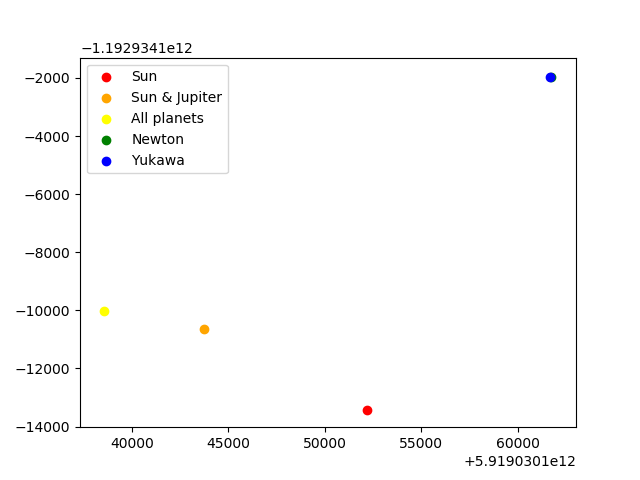

In [14]:
# Dessin
plt.figure(8)
plt.scatter(X_sun[-1], Y_sun[-1], c = 'r', label = "Sun")
plt.scatter(X_sun_and_jupyter[-1], Y_sun_and_jupyter[-1], c = 'orange', label = "Sun & Jupiter")
plt.scatter(X_all_planets[-1], Y_all_planets[-1], c = 'yellow', label = "All planets")
plt.scatter(X_all_forces[-1], Y_all_forces[-1], c = 'g', label = "Newton")
plt.scatter(X_Yukawa[-1], Y_Yukawa[-1], c = 'b', label = "Yukawa")
plt.legend()
plt.show()

Les courbes précédentes ont été tracées pour :

$\bullet$ $t_{start} =$ 01/01/2015

$\bullet$ $t_{end} =$ 01/02/2015

$\bullet$ $\Delta t = 2.6$ s

$\bullet$ $\epsilon = 0.5$

$\bullet$ $R = 6.3 ~ 10^{-1}$ m

$\bullet$ $m = 10^{2}$ kg

$\bullet$ $v_{vent} = 4.5 ~ 10^{5}$ m/s

$\bullet$ $\alpha = 10^{-4}$

$\bullet$ $\lambda = 10^{12}$ m

# Sources

[1] Satellite Orbits, O. Montenbruck & E. Gill.

[2] Using Spherical Harmonics To Model Solar Radiation Pressure Acceleration, A. Farrès & D. Folta & C. Webster.

[3] http://www.lesia.obspm.fr/Caracteristiques-generales-du-vent.html

[4] Testing Long-distance Modification Of Gravity Up To 100 Astronomical Units, B. Buscaino & D. DeBra & P. W. Graham & G. Gratta & T. D. Wiser, Physical Review D 92, 2015

[5] https://fr.wikipedia.org/wiki/Poussi%C3%A8re_interstellaire

# Remarques

$\bullet$ $Poussières ~ interstellaires$: densité d'environ $10^{-6} ~ part. / m^{3}$, et masse d'environ $10^{-17} g / part.$ [5]. Donc si on suppose un coefficient de trainée de 1, on obtient une force 9 ordres de grandeurs en dessous de la force gravitationelle. C'est négligeable.

$\bullet$ $Forces ~ Thermopropulsives$: Ca pourrait être intéressant de les considérer, au vu des résultats de Pioneer.

$\bullet$ $Vent ~ Solaire$: Très modèle-dépendant, on le laisse de coté pour le moment.